# SELF ATTENTION
Costituisce la base dell'architettura Transformer: rappresenta il meccanismo sulla base del quale vengono calcolati gli attention wheigts tra i token presenti nelle diverse posizione della sequenza di input.<br>
Obiettivo della self attention è calcolare un context vector, per ciascun elemento presente nella sequenza di input, che combini informazioni da tutti gli altri elementi. In pratica un context vector può essere interpretato con un embedding vector "arricchito".

Come primo esempio prenderemo in esame una versione semplificata del meccanismo (senza trainable weights).

Definiamo innanzi tutto una sequenza di input (con embeddings di dimensione 3 a titolo esemplificativo). 

In [1]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

/home/michele/dev/python/build_GPT/.venv/lib/python3.10/site-packages/torch/_subclasses/functional_tensor.py:275: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:81.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


Come primo step andiamo a calcolare gli attention scores tra query token e ciascun input token facendo il dot product

In [2]:
# The second input token serves as the query. 
query = inputs[1]                            
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


Una volta ottenuti gli attention scores è necessario normalizzarli (la somma deve essere  = 1)

In [3]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


In realtà per normalization si utilizza Softmax:
- gestisce meglio valori estremi 
- è meglio x favorire il processo di gradient descent)
- assicura che tutti i valori siano positivi e quindi che possano essere interpretati come probabilità

In [4]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


E' meglio utilizzare l'implementazione di Softmax di Pytorch in quanto più stabile e efficiente

In [5]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


Dopo aver calcolato gli attention weights è possibile calcolare il context vector moltiplicando l'input token con il weight corrispondente e sommando il vettore risultante.<br>
Il context vector è quindi la somma ponderata di tutti gli input vector

In [6]:
# The second input token is the query
query = inputs[1]        
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


E' ora possibile generalizzare questo processo per calcolare attention weigths per tutti i token.

Gli step sono gli stessi di prima tranne che per il fatto che vengono calcolati tutti i context vector anziche uno solo

In [7]:
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)


tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


Ciascun elemento del tensor rapprenseta attention score tra ciascuna copia di elementi di input. 

E' possibile ottenere lo stesso risultato usando matrix multiplication invece del for loop

In [8]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


A questo punto si può procedere con la normalizzazione

In [9]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


Una volta ottenuti gli attention weights (normalizzati) è possibile ottenere il context vector via matrix multiplication

In [10]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


# SELF ATTENTION CON TRAINABLE PARAMETERS

Rispetto a quanto visto finora vengono introdotti delle weights matrices che verranno aggiornate durante il training del modello.
Le weights matrices sono 3 (Wq, Wk, Wv)

A titolo di esempio definiamo alcune variabili

In [11]:
# The second input element 
x_2 = inputs[1]    

# The input embedding size, d=3 
d_in = inputs.shape[1]      

# The output embedding size, d_out=2 
d_out = 2         

Inizializiamo 3 weights matrices

In [12]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [13]:
query_2 = x_2 @ W_query 
key_2 = x_2 @ W_key 
value_2 = x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])


Calcolando su tutti itoken di input

In [14]:
keys = inputs @ W_key 
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


Secondo step è calcolare gli attention score.

Inizialmente calcoliamo solo l'attention score per il secondo token 

In [15]:
keys_2 = keys[1]       
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


Questo può essere generalizzato per calcolare tutti gli attention score via matrix multiplication

In [16]:
# All attention scores for given query 
attn_scores_2 = query_2 @ keys.T     
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


Per passare da attention scores ad attention weights dobbiamo applicare Softmax dopo aver scalato gli attention scores (dividendo per la radice quadrata della dimensione degli embedding delle key)

In [17]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


Ultimo step è calcolare i context vector 

In [18]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


## Self Attention class

E' possibile implementare una classe che organizzi i calcoli visti in precedenza

In [19]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

Questa classe può essere utilizzata 

In [20]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


E' possibile migliorare la precedente versione della classe utilizzando nn.Linear al posto di nn.Parameter in quanto più efficiente

In [21]:
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

In [22]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


Gli output sono diversi dai precedenti in quanto con nn.Linear si usa un diverso criterio di inizializzazione dei weights

# Causal Attention

Serve per impedire al modello di accedere ad informazioni relative a token "futuri" in quanto la previsione del prossimo token deve basarsi solo sui token precedenti

Come primo step calcoliamo gli attention wheights come prima

In [23]:
# Reuses the query and key weight matrices of the SelfAttention_v2 object from the previous section for convenience 

queries = sa_v2.W_query(inputs)    
keys = sa_v2.W_key(inputs) 
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


A questo punto si utilizza la funzione tril() per avere la matrice triangolare (in cui i valori al di sopra della diagonale sono zero) che serve per calcolare causal self attention

In [24]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


A questo punto posso moltiplicare gli attention weights x la matrice diagonale per ottenere i masked attention weights

In [25]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


A questo punto è possibile ri-normalizzare per ogni riga in modo che la somma sia 1

In [26]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


E' possibile ottenere lo stesso risultato in modo più efficiente sostituendo con -infinito i valori mascherati e applicando la softmax function direttamente (softmax converte gli input in una probability ditribution e tratta -inf come zero probabilità)

In [27]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


Ora è sufficiente applicare direttamente softmax ed ottenere lo stesso risultato di prima in modo più efficiente

In [28]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


Prima di utilizzare i masked attention weigthts per calcolare il context vector (context_vec = attn_weights @ values) è necessario introdurre il meccanismo di dropout per prevenire overfitting.

Per implementare dropout è necessario applicare una dropout mask che annulli alcuni degli masked attention weights precedentemente calcolati. Per compensare i valori rimanenti sono scalati a 2 (1/0,5)

In [29]:
torch.manual_seed(123)

# We choose a dropout rate of 50%.
dropout = torch.nn.Dropout(0.5)   

# Here, we create a matrix of 1s
example = torch.ones(6, 6)   
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


Ora è possibile applicare questa maschera di dropout ai masked attention weights

In [30]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


E' ora possibile modificare la precedente classe SelfAttention_v2 per incorporare il meccanismo di causal attention e dropout.<BR>
Prima di implementare questa classe andiamo però a creare un batch di input (duplicando l'input precedente)

In [31]:
# Two inputs with six tokens each; each token has embedding dimension 3. 

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)              

torch.Size([2, 6, 3])


In [32]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length,
                dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        # Compared to the previous SelfAttention_v1 class, we added a dropout layer. 
        self.dropout = nn.Dropout(dropout)           
        
        # The register_buffer call is also a new addition (more information is provided in the following text). 
        self.register_buffer(
           'mask',
           torch.triu(torch.ones(context_length, context_length),
           diagonal=1)
        )            

    def forward(self, x):

        b, num_tokens, d_in = x.shape                   
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We transpose dimensions 1 and 2, keeping the batch dimension at the first position (0). 
        attn_scores = queries @ keys.transpose(1, 2)   

        # In PyTorch, operations with a trailing underscore are performed in-place, avoiding unnecessary memory copies. 
        attn_scores.masked_fill_(                    
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf) 
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ values
        return context_vec


Questa classe può essere usata come la precedente

In [33]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


# Multi-head Attention

Consiste nell'applicare il meccanismo di self attention precedentemente implementato più volte in modo indipendente con propri weigth matrix per ogni head e alla fine sommare gli outputs (context matrix).<br>
INizialmente verrà implementato in modo sequenziale (una head dopo l'altra in un ciclo for). Successivamente l'algoritmo verrà ottimizzato

In [34]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length,
                 dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(
                 d_in, d_out, context_length, dropout, qkv_bias
             ) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

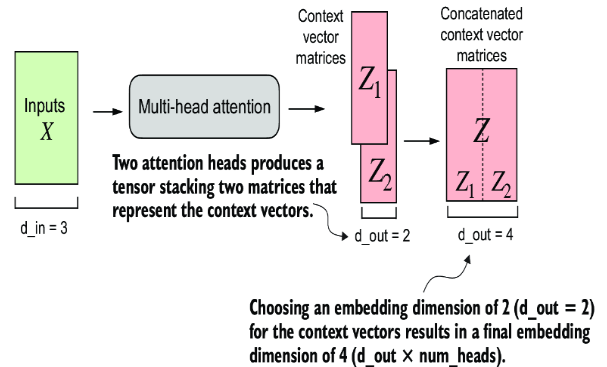

In [35]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)
context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


E' ora possibile creae un'unica classe MultiHeadAttention che unisca le classi CausalAttention e MultiHeadAttentionWrapper. Inoltre è possibile effettuare alcune ottimizzazioni (weights plit).

La classe sottostante è più complicata ma più efficiente in quanto utilizza un'unica matrix multiplication invece che più matrix multiplication in un ciclo for

In [37]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, 
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        
        # Reduces the projection dim to match the desired output dim
        self.head_dim = d_out // num_heads   
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # Uses a Linear layer to combine head outputs 
        self.out_proj = nn.Linear(d_out, d_out)    
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # Per tutti e 3 il tensor shape: (b, num_tokens, d_out) 
        keys = self.W_key(x)         
        queries = self.W_query(x)    
        values = self.W_value(x)     

        # We implicitly split the matrix by adding a num_heads dimension. 
        # Then we unroll the last dim: (b, num_tokens, d_out) -&gt; (b, num_tokens, num_heads, head_dim). 
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)      
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)  
        queries = queries.view(                                             
            b, num_tokens, self.num_heads, self.head_dim                    
        )                                                                   

        # Transposes from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim) 
        keys = keys.transpose(1, 2)          
        queries = queries.transpose(1, 2)    
        values = values.transpose(1, 2)      

        # Computes dot product for each head 
        attn_scores = queries @ keys.transpose(2, 3) 

        # Masks truncated to the number of tokens 
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]    

        # Uses the mask to fill attention scores 
        attn_scores.masked_fill_(mask_bool, -torch.inf)     

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Tensor shape: (b, num_tokens, n_heads, head_dim) 
        context_vec = (attn_weights @ values).transpose(1, 2)  

        # Combines heads, where self.d_out = self.num_heads * self.head_dim 
        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )

        # Adds an optional linear projection 
        context_vec = self.out_proj(context_vec)    
        return context_vec

Il parametro d_out controlla la dimensione del context vector prodotto

In [38]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)


tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


Nei  veri GPT model la dimensione dei token input e context embedding è la stessa (d_in=d_out).